In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lshash import LSHash
from math import radians, cos, sin, asin, sqrt
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def input():

    # file input
    data = pd.read_csv('data_2g.csv', index_col=None)
    gongcan = pd.read_csv('2g_gongcan.csv', index_col=None)

    # data merge
    for i in range(1, 8):
        gongcan_temp = gongcan.rename(columns={'RNCID': 'RNCID_' + str(i),'CellID': 'CellID_' + str(i),'Latitude': 'Latitude_' + str(i),'Longitude': 'Longitude_' + str(i)})
        data = pd.merge(data, gongcan_temp, how='left', on=['RNCID_' + str(i), 'CellID_' + str(i)])
        
    return data


def classify(data):

    # get the area
    lat = haversine(121.20120490000001, 31.28175691, 121.20120490000001, 31.29339344)*1000
    lon = haversine(121.20120490000001, 31.28175691, 121.2183295, 31.28175691)*1000
    width = 20

    # create Grid ID
    lon_grid = int(lon/width)
    lon_width = (121.2183295-121.20120490000001)/lon_grid
    lat_grid = int(lat/width)
    lat_width = (31.29339344-31.28175691)/lat_grid

    # transfer Longitude,Latitude into Grid ID
    data['lon_grid'] = (data['Longitude']-121.20120490000001)/lon_width
    data['lat_grid'] = (data['Latitude']-31.28175691)/lat_width
    data['lon_grid'] = data['lon_grid'].apply(int)
    data['lat_grid'] = data['lat_grid'].apply(int)
    data['grid'] = data['lon_grid'] + data['lat_grid']*lon_grid

    return data


def reverse(result):

    # get the area
    lat = haversine(121.20120490000001, 31.28175691, 121.20120490000001, 31.29339344)*1000
    lon = haversine(121.20120490000001, 31.28175691, 121.2183295, 31.28175691)*1000
    width = 20

    # create Grid ID
    lon_grid = int(lon/width)
    lon_width = (121.2183295-121.20120490000001)/lon_grid
    lat_grid = int(lat/width)
    lat_width = (31.29339344-31.28175691)/lat_grid

    # transfer Grid ID into Longitude,Latitude
    result['lat_grid'] = result['grid']/lon_grid
    result['lat_grid'] = result['lat_grid'].apply(int)
    result['lon_grid'] = result['grid'] - result['lat_grid']*lon_grid
    result['Longitude_pred'] = (result['lon_grid']+0.5)*lon_width+121.20120490000001
    result['Latitude_pred'] = (result['lat_grid']+0.5)*lat_width+31.28175691

    return result.drop(['lat_grid','lon_grid'], axis=1)


def evaluate(test_set, result_set):

    # calculate the abs range
    compare_set = pd.concat([test_set.reset_index(drop=True), result_set.reset_index(drop=True)], axis=1, ignore_index=True)
    compare_set['lon_dev'] = abs(compare_set[0] - compare_set[3])
    compare_set['lat_dev'] = abs(compare_set[1] - compare_set[4])
    
    # calculate the deviation
    compare_set['error'] = compare_set['lon_dev'] + compare_set['lat_dev']
    compare_set = compare_set.sort_values(['error'])

    # get point
    deviation = [0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        deviation.append(haversine(compare_set.iloc[int(i*compare_set.shape[0]), ]['error'],0,0,0)*1000)

    return deviation


def createInitSet(data):

    # create training set
    training_set = data.sample(frac=0.8).sort_index()
    training_labels = training_set['grid']
    training_features = training_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','lon_grid','lat_grid','grid','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    # create test set
    test_set = data.append(training_set).drop_duplicates(keep=False).sort_index()
    test_labels = test_set['grid'].values
    test_pos = pd.DataFrame()
    test_pos['Longitude'] = test_set['Longitude']
    test_pos['Latitude'] = test_set['Latitude']
    test_features = test_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','lon_grid','lat_grid','grid','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    return training_features, test_features, training_labels, test_labels, test_pos

def modify_pred(predicted):

    # get the area
    lat = haversine(121.20120490000001, 31.28175691, 121.20120490000001, 31.29339344)*1000
    lon = haversine(121.20120490000001, 31.28175691, 121.2183295, 31.28175691)*1000
    width = 20

    # create Grid ID
    lon_grid = int(lon/width)
    lon_width = (121.2183295-121.20120490000001)/lon_grid
    lat_grid = int(lat/width)
    lat_width = (31.29339344-31.28175691)/lat_grid

    # modify the pred with the near result
    last = predicted[0]
    for pos in range(0, predicted.size):
        # error permit is about 200m
        if pos != predicted.size-1 and ((abs(int(predicted[pos]/lon_grid)-int(last/lon_grid)) < 10 and abs(int(predicted[pos]/lat_grid)-int(last/lat_grid)) < 10) or (abs(int(predicted[pos]/lon_grid)-int(predicted[pos+1]/lon_grid)) < 10 and abs(int(predicted[pos]/lat_grid)-int(predicted[pos+1]/lat_grid)) < 10)):
            last = predicted[pos]
        elif pos == predicted.size-1:
            last = predicted[pos]
        else:
            predicted[pos] = last
    return predicted


GaussianNB CDF:


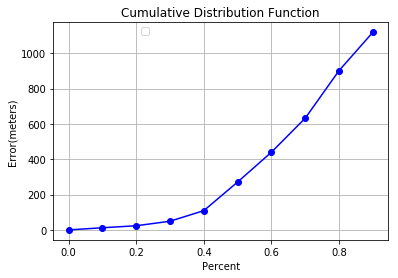

Precision: 0.10178230079295529
Recall: 0.12303278490493101
F1: 0.09728527459201175
GaussianNB CDF:


D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


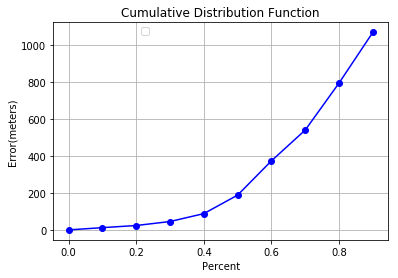

Precision: 0.09736224817494166
Recall: 0.12311538650547936
F1: 0.09489904353926631
KNeighborsClassifier CDF:


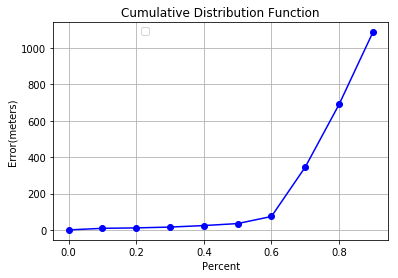

Precision: 0.1551736417069187
Recall: 0.17987382987382988
F1: 0.1511884185991125
KNeighborsClassifier CDF:


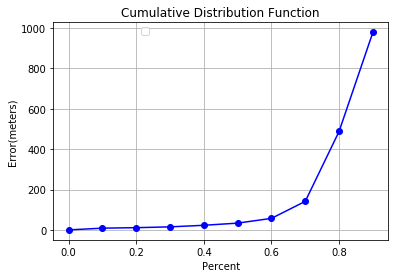

Precision: 0.16104272696253827
Recall: 0.18740285745002727
F1: 0.15629997766874665
DecisionTreeClassifier CDF:


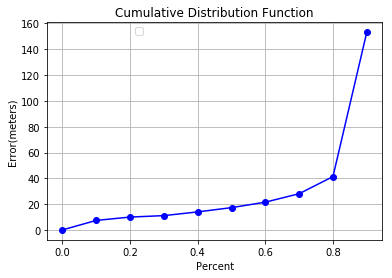

Precision: 0.2777378608919385
Recall: 0.28353963277544064
F1: 0.26393717707526926
DecisionTreeClassifier CDF:


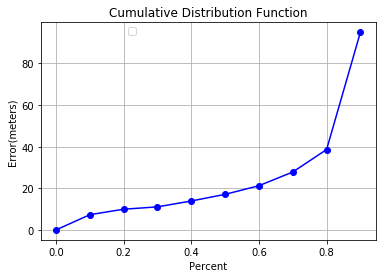

Precision: 0.2809593425402442
Recall: 0.28909792681916574
F1: 0.26802533296218417
RandomForestClassifier CDF:


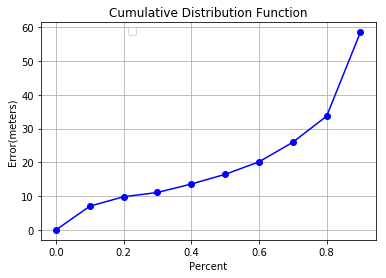

Precision: 0.27980532156959687
Recall: 0.29466871179901927
F1: 0.26890196262083094
RandomForestClassifier CDF:


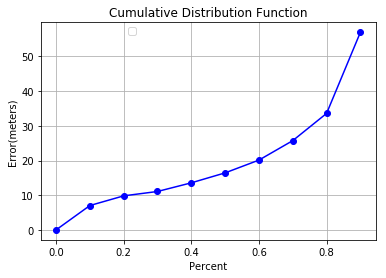

Precision: 0.2804585179401895
Recall: 0.2951007773588419
F1: 0.2687580968719368


In [2]:
if __name__ == '__main__':

    # input
    data_set = input()
    data_set = classify(data_set)

    # init data set
    training_set, test_set, training_labels, test_labels, test_pos = createInitSet(data_set)

    # GaussianNB
    # train
    clf = GaussianNB().fit(training_set, training_labels)

    # test
    pred = clf.predict(test_set)

    for i in range(0, 2):

        if i == 1:

            # modify result
            pred = modify_pred(pred)

        # transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

        # calculate the deviation
        print 'GaussianNB CDF:'
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, evaluate(test_pos, result),'bo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()

        # Precision
        print 'Precision:', precision_score(test_labels, pred, average='macro')

        # Recall
        print 'Recall:', recall_score(test_labels, pred, average='macro')

        # F-measurement
        print 'F1:', f1_score(test_labels, pred, average='macro')
        
        # get report
        #print 'GaussianNB report:\n', classification_report(test_labels, pred)

    # KNeighborsClassifier
    # train
    clf = KNeighborsClassifier().fit(training_set, training_labels)

    # test
    pred = clf.predict(test_set)

    for i in range(0, 2):

        if i == 1:

            # modify result
            pred = modify_pred(pred)

		# transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

		# calculate the deviation
        print 'KNeighborsClassifier CDF:'
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, evaluate(test_pos, result),'bo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()

		# Precision
        print 'Precision:', precision_score(test_labels, pred, average='macro')

		# Recall
        print 'Recall:', recall_score(test_labels, pred, average='macro')

		# F-measurement
        print 'F1:', f1_score(test_labels, pred, average='macro')

		# get report
        #print 'KNeighborsClassifier report:\n', classification_report(test_labels, pred)

    # DecisionTreeClassifier
    # train
    clf = DecisionTreeClassifier().fit(training_set, training_labels)

    # test
    pred = clf.predict(test_set)

    for i in range(0, 2):

        if i == 1:

            # modify result
            pred = modify_pred(pred)

		# transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

		# calculate the deviation
        print 'DecisionTreeClassifier CDF:'
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, evaluate(test_pos, result),'bo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()

		# Precision
        print 'Precision:', precision_score(test_labels, pred, average='macro')

		# Recall
        print 'Recall:', recall_score(test_labels, pred, average='macro')

		# F-measurement
        print 'F1:', f1_score(test_labels, pred, average='macro')

		# get report
        #print 'DecisionTreeClassifier report:\n', classification_report(test_labels, pred)

    # RandomForestClassifier
    # train
    clf = RandomForestClassifier().fit(training_set, training_labels)

    # test
    pred = clf.predict(test_set)

    for i in range(0, 2):

        if i == 1:

            # modify result
            pred = modify_pred(pred)

		# transform into real pos
        result = reverse(pd.DataFrame(data=pred, columns=['grid']))

		# calculate the deviation
        print 'RandomForestClassifier CDF:'
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, evaluate(test_pos, result),'bo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()

        # Precision
        print 'Precision:', precision_score(test_labels, pred, average='macro')

		# Recall
        print 'Recall:', recall_score(test_labels, pred, average='macro')

		# F-measurement
        print 'F1:', f1_score(test_labels, pred, average='macro')
        
		# get report
        #print 'RandomForestClassifier report:\n', classification_report(test_labels, pred)

